In [1]:
from scipy.ndimage import zoom
import numpy as np

def shrinkpad(image):
    original_shape = image.shape
    # Shrink the image by a factor of two
    shrunken_image = zoom(image, 0.5)

    # Calculate the padding required
    pad_height = original_shape[0] - shrunken_image.shape[0]
    pad_width = original_shape[1] - shrunken_image.shape[1]

    # Pad the shrunken image to the original shape
    padded_image = np.pad(shrunken_image, ((pad_height // 2, pad_height // 2), (pad_width // 2, pad_width // 2)), mode='constant')
    return padded_image

def zoomclip(image):
    n, m = image.shape
    zoomed = zoom(image, 2)
    return zoomed[n // 2: -n // 2, m // 2: -m // 2]

def gaussian_2d(x, y, mux, muy, sigmax, sigmay):
    return np.exp(-((x - mux)**2 / (2 * sigmax**2) + (y - muy)**2 / (2 * sigmay**2)))

def create_gaussian_envelope(N, sigma):
    mux = muy = N / 2
    sigmax = sigmay = sigma
    x = np.linspace(0, N-1, N)
    y = np.linspace(0, N-1, N)
    X, Y = np.meshgrid(x, y)
    
    gaussian = gaussian_2d(X, Y, mux, muy, sigmax, sigmay)
    normalized_gaussian = gaussian / np.max(gaussian)
    
    return normalized_gaussian

def crop_to_non_uniform_region_with_buffer(img_array, buffer=0):
    """
    Crop the image to the non-uniform region with an additional buffer in each direction.

    Parameters:
    - img_array: The numpy array of the image.
    - buffer: The number of pixels to expand the cropped region in each direction.

    Returns:
    - cropped_img_array: The numpy array of the cropped image.
    """

    # Convert to grayscale if it is not already
    if len(img_array.shape) == 3:
        gray_img_array = img_array[:, :, 0]
    else:
        gray_img_array = img_array

    # Find the background pixel value, assuming it is the mode of the corner pixels
    corner_pixels = [gray_img_array[0, 0], gray_img_array[0, -1], gray_img_array[-1, 0], gray_img_array[-1, -1]]
    background_pixel = max(set(corner_pixels), key=corner_pixels.count)

    # Detect the non-uniform region
    rows, cols = np.where(gray_img_array != background_pixel)
    if rows.size > 0 and cols.size > 0:
        row_min, row_max, col_min, col_max = rows.min(), rows.max(), cols.min(), cols.max()
        # Apply the buffer, ensuring we don't go out of the image bounds
        row_min = max(row_min - buffer, 0)
        row_max = min(row_max + buffer, gray_img_array.shape[0] - 1)
        col_min = max(col_min - buffer, 0)
        col_max = min(col_max + buffer, gray_img_array.shape[1] - 1)
    else:
        raise ValueError("No non-uniform region found")

    # Crop the image to the non-uniform region with the buffer
    cropped_img_array = gray_img_array[row_min:row_max+1, col_min:col_max+1]

    return cropped_img_array

def summarize(i, a, b, X_test, Y_I_test, Y_phi_test, probe, channel = 0, save_path='frames', show = True, **kwargs):
    plt.rcParams["figure.figsize"] = (6, 6)
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(2, 2)

    # Ground truth amplitude
    axs[0, 0].set_title('Ground Truth Amplitude')
    ground_truth_amp = np.abs(np.abs(obj['probeGuess']) * Y_I_test[i, ..., channel])
    cropshow(ground_truth_amp, ax=axs[0, 0], cmap='viridis', **kwargs)
    axs[0, 0].axis('off')

    # Reconstructed amplitude
    axs[0, 1].set_title('Reconstructed Amplitude')
    reconstructed_amp = np.abs(b[i, ..., channel])
    cropshow(np.abs(obj['probeGuess']) * reconstructed_amp, ax=axs[0, 1], cmap='viridis', **kwargs)
    axs[0, 1].axis('off')

    # Ground truth diffraction pattern (log scale)
    axs[1, 0].set_title('Ground Truth Diffraction')
    ground_truth_diff = np.log(X_test[i, ..., channel])
    cropshow(ground_truth_diff, ax=axs[1, 0], cmap='plasma', crop = False, **kwargs)
    axs[1, 0].axis('off')

    # Reconstructed diffraction pattern (log scale)
    axs[1, 1].set_title('Reconstructed Diffraction')
    reconstructed_diff = np.log(a[i, ..., channel])
    cropshow(reconstructed_diff, ax=axs[1, 1], cmap='plasma', crop = False, **kwargs)
    axs[1, 1].axis('off')

    plt.tight_layout()
    if show:
        plt.show()
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f'{save_path}/frame_{i}.png')
    plt.close()
    
def show_diffraction(i, a, b, X_test, Y_I_test, Y_phi_test, probe, channel = 0,
                       save_path='frames', show = True, **kwargs):
    plt.rcParams["figure.figsize"] = (6, 6)
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(1, 1)

    # Reconstructed diffraction pattern (log scale)
    axs.set_title('Reconstructed Diffraction')
    reconstructed_diff = np.log(a[i, ..., channel])
    cropshow(reconstructed_diff, ax=axs, cmap='plasma', crop = False, **kwargs)
    axs.axis('off')

    plt.tight_layout()
    if show:
        plt.show()
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f'{save_path}/frame_{i}.png')
    plt.close()


def show_amplitude(i, a, b, X_test, Y_I_test, Y_phi_test, probe, channel = 0,
                     save_path='frames', show = True, **kwargs):
    plt.rcParams["figure.figsize"] = (6, 6)
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(1, 1)

    # Reconstructed amplitude
    axs.set_title('Reconstructed Amplitude')
    reconstructed_amp = np.abs(b[i, ..., channel])
    cropshow(np.abs(p.get('probe')[..., 0]) * reconstructed_amp, ax=axs, cmap='viridis', **kwargs)
    axs.axis('off')

    plt.tight_layout()
    if show:
        plt.show()
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f'{save_path}/frame_{i}.png')
    plt.close()
    
    
    
def create_animation(imax, istep, a, b, X_test, Y_I_test, Y_phi_test, probe, channel=0, 
                     name = 'animation.gif', type = 'all',  **kwargs):
    if type == 'all':
        fn = summarize
    elif type == 'diffraction':
        fn = show_diffraction
    elif type == 'amplitude':
        fn = show_amplitude
    else:
        raise ValueError
    frames = []
    for i in range(0, imax, istep):
        fn(i, a, b, X_test, Y_I_test, Y_phi_test, probe, channel, **kwargs)
        frames.append(imageio.imread(f'frames/frame_{i}.png'))
    
    # Create GIF
    imageio.mimsave(name, frames, fps=2)

# Placeholder cropshow function definition as provided
def cropshow(arr, ax=None, crop=True, *args, **kwargs):
    if crop:
        arr = arr[16:-16, 16:-16]
    if ax is None:
        plt.imshow(arr, *args, **kwargs)
    else:
        ax.imshow(arr, *args, **kwargs)

import imageio

def plot_xpp_phase():

    # Extract the amplitude and phase from the probe guess
    probe_amplitude = np.abs(obj['probeGuess'])
    probe_phase = np.angle(obj['probeGuess'])

    # Create a pretty figure with subplots for the probe amplitude and phase
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the probe amplitude
    amp_img = axs[0].imshow(probe_amplitude, cmap='viridis')
    axs[0].set_title('Probe Amplitude')
    axs[0].axis('off')  # Hide axes ticks
    fig.colorbar(amp_img, ax=axs[0], orientation='vertical')

    # Plot the probe phase
    phase_img = axs[1].imshow(probe_phase, cmap='twilight_shifted')
    axs[1].set_title('Probe Phase')
    axs[1].axis('off')
    fig.colorbar(phase_img, ax=axs[1], orientation='vertical')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)

    plt.show()


def reconstruct_image(which = 'full'):
    Y_test = hh.combine_complex(Y_I_test, Y_phi_test)
    global_offsets = xpp.dset[xpp.key_coords_offsets]
    local_offsets = xpp.dset[xpp.key_coords_relative]

#     global_offsets_test = xpp.split_tensor(
#         xpp.dset[xpp.key_coords_offsets], 'test')
#     local_offsets_test = xpp.split_tensor(
#         xpp.dset[xpp.key_coords_relative], 'test')

    obj_tensor_full, _, _ = model.autoencoder.predict(
                    [xpp.X_full * model.params()['intensity_scale'],
                                    xpp.dset[xpp.key_coords_relative]])
    return obj_tensor_full, global_offsets, local_offsets

# global_offsets_test = xpp.split_tensor(
#     xpp.dset[xpp.key_coords_offsets], 'test')
# local_offsets_test = xpp.split_tensor(
#     xpp.dset[xpp.key_coords_relative], 'test')

# # obj_tensor_test, _, _, _ = model.autoencoder.predict(
# #                 [X_test * model.params()['intensity_scale'],
# #                                 local_offsets_test])
# mask = (hh.mk_centermask(obj_tensor_full, 64, 1))

def plot_epie_comparison_2x3():
    # Create a 2x3 subplot
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # PtychoPINN phase with color bar
    ptycho_pinn_phase_img = axs[0, 0].imshow(ptycho_pinn_phase, cmap='gray')
    axs[0, 0].set_title('PtychoPINN Phase')
    axs[0, 0].axis('off')
    fig.colorbar(ptycho_pinn_phase_img, ax=axs[0, 0], orientation='vertical')

    # ePIE phase with color bar
    epie_phase_img = axs[0, 1].imshow(epie_phase, cmap='gray')
    axs[0, 1].set_title('ePIE Phase')
    axs[0, 1].axis('off')
    fig.colorbar(epie_phase_img, ax=axs[0, 1], orientation='vertical')

    # Supervised amplitude with color bar (moved to the 3rd position of the first row)
    supervised_amplitude_img = axs[0, 2].imshow(supervised_amplitude, cmap='gray')
    axs[0, 2].set_title('Supervised Amplitude')
    axs[0, 2].axis('off')
    fig.colorbar(supervised_amplitude_img, ax=axs[0, 2], orientation='vertical')

    # PtychoPINN amplitude with color bar
    ptycho_pinn_amplitude_img = axs[1, 0].imshow(ptycho_pinn_amplitude, cmap='gray')
    axs[1, 0].set_title('PtychoPINN Amplitude')
    axs[1, 0].axis('off')
    fig.colorbar(ptycho_pinn_amplitude_img, ax=axs[1, 0], orientation='vertical')

    # ePIE amplitude with color bar
    epie_amplitude_img = axs[1, 1].imshow(epie_amplitude, cmap='gray')
    axs[1, 1].set_title('ePIE Amplitude')
    axs[1, 1].axis('off')
    fig.colorbar(epie_amplitude_img, ax=axs[1, 1], orientation='vertical')

    # Supervised phase with color bar (moved to the 3rd position of the second row)
    supervised_phase_img = axs[1, 2].imshow(supervised_phase, cmap='gray')
    axs[1, 2].set_title('Supervised Phase')
    axs[1, 2].axis('off')
    fig.colorbar(supervised_phase_img, ax=axs[1, 2], orientation='vertical')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=3.0)

    plt.show()
    
def mk_epie_comparison2x2():
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # PtychoPINN phase with color bar
    ptycho_pinn_phase_img = axs[0, 0].imshow(ptycho_pinn_phase, cmap='gray')
    axs[0, 0].set_title('PtychoPINN Phase')
    axs[0, 0].axis('off')
    fig.colorbar(ptycho_pinn_phase_img, ax=axs[0, 0], orientation='vertical')

    # ePIE phase with color bar
    epie_phase_img = axs[0, 1].imshow(epie_phase, cmap='gray')
    axs[0, 1].set_title('ePIE Phase')
    axs[0, 1].axis('off')
    fig.colorbar(epie_phase_img, ax=axs[0, 1], orientation='vertical')

    # PtychoPINN amplitude with color bar
    ptycho_pinn_amplitude_img = axs[1, 0].imshow(ptycho_pinn_amplitude, cmap='gray')#,
                                               # vmin = .2
    axs[1, 0].set_title('PtychoPINN Amplitude')
    axs[1, 0].axis('off')
    fig.colorbar(ptycho_pinn_amplitude_img, ax=axs[1, 0], orientation='vertical')

    # ePIE amplitude with color bar
    epie_amplitude_img = axs[1, 1].imshow(epie_amplitude, cmap='gray')
    axs[1, 1].set_title('ePIE Amplitude')
    axs[1, 1].axis('off')
    fig.colorbar(epie_amplitude_img, ax=axs[1, 1], orientation='vertical')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=3.0)

    plt.show()

gaussian_envelope = 1. * create_gaussian_envelope(64, 5)

# Demo init
def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = True
    p.cfg['data_source'] = 'xpp'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 100
    
    p.cfg['nll_weight'] = 1.
    p.cfg['mae_weight'] = 0.
    p.cfg['tv_weight'] = 0#50#1e1#1e1
    
    p.cfg['probe_scale'] = 5

    p.cfg['offset'] = 4
    p.cfg['sim_jitter_scale'] = 0.#0.1
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 1
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['probe.big'] = True
    
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e9
    
    p.cfg['outer_offset_train'] = None
    p.cfg['outer_offset_test'] = None
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1

# XPP probe simulation (inc. phase) with lines dataset

This demonstrates the ability to reconstruct in CDI mode, when the probe is asymmetric

In [2]:
def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = False
    p.cfg['data_source'] = 'lines'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 60
    
    p.cfg['nll_weight'] = 1.
    p.cfg['mae_weight'] = 0.
    p.cfg['tv_weight'] = 0#1e1

    p.cfg['offset'] = 4
    p.cfg['sim_jitter_scale'] = 0.
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 1
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['probe.big'] = True
    
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e9
    
    p.cfg['outer_offset_train'] = 8
    p.cfg['outer_offset_test'] = 20
    p.cfg['nimgs_train'] = 2
    p.cfg['nimgs_test'] = 1

In [3]:
init()

from ptycho import tf_helper
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(obj['probeGuess'])
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, obj['probeGuess'])

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

2023-12-08 13:43:27.668634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 13:43:27.764475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 13:43:28.136441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-12-08 13:43:28.136482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (1024, 64, 64, 1)


In [4]:
from ptycho import params as p
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'tmp'
p.cfg['n_filters_scale'] = 2

from ptycho import train, model
from ptycho.train import *

Loading result from disk cache.
Loading result from disk cache.
0.99998814
nphoton 9.264364
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['t

                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15

2023-12-08 13:48:58.689026: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-12-08 13:48:58.689042: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-12-08 13:48:58.689071: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-12-08 13:48:58.693337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-12-08 13:48:58.748982: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-12-08 13:48:58.749076: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/60
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2023-12-08 13:49:01.158631: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7f77370
2023-12-08 13:49:01.901632: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


819/819 [==============================] - 16s 15ms/step - loss: 270076448.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 37.8866 - distribution_lambda_loss: 270076448.0000 - val_loss: 5180540.5000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 18.6691 - val_distribution_lambda_loss: 5180540.5000 - lr: 0.0010
Epoch 2/60
819/819 [==============================] - 12s 15ms/step - loss: 5249179.5000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 18.7123 - distribution_lambda_loss: 5249179.5000 - val_loss: 5122800.5000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 18.7463 - val_distribution_lambda_loss: 5122800.5000 - lr: 0.0010
Epoch 3/60
819/819 [==============================] - 12s 15ms/step - loss: 4742635.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 17.9073 - distribution_lambda_loss: 4742635.0000 - val_loss: 4681349.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 17.8626 - val_distribution

In [5]:
X_train.shape

(13778, 64, 64, 1)

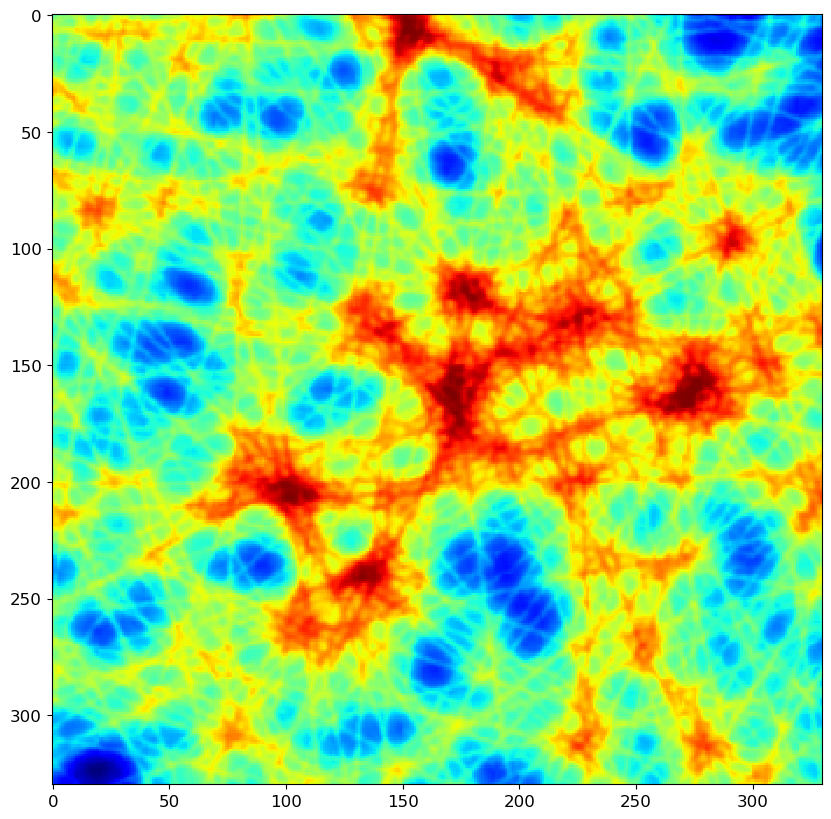

In [6]:
plt.rcParams["figure.figsize"] = (10, 10)

import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

In [6]:
X_test.shape

TensorShape([1089, 64, 64, 1])

In [10]:
animation_html = create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0, name = 'lines_xpp_probe.gif', show = False)

/tmp/ipykernel_1032486/122268144.py:95: RuntimeWarning: divide by zero encountered in log
  ground_truth_diff = np.log(X_test[i, ..., channel])
/tmp/ipykernel_1032486/122268144.py:130: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frames/frame_{i}.png'))


phase min: -0.2463119 phase max: 1.7310104


/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/ptychoPINN-0.0.0-py3.9.egg/ptycho/evaluation.py:80: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


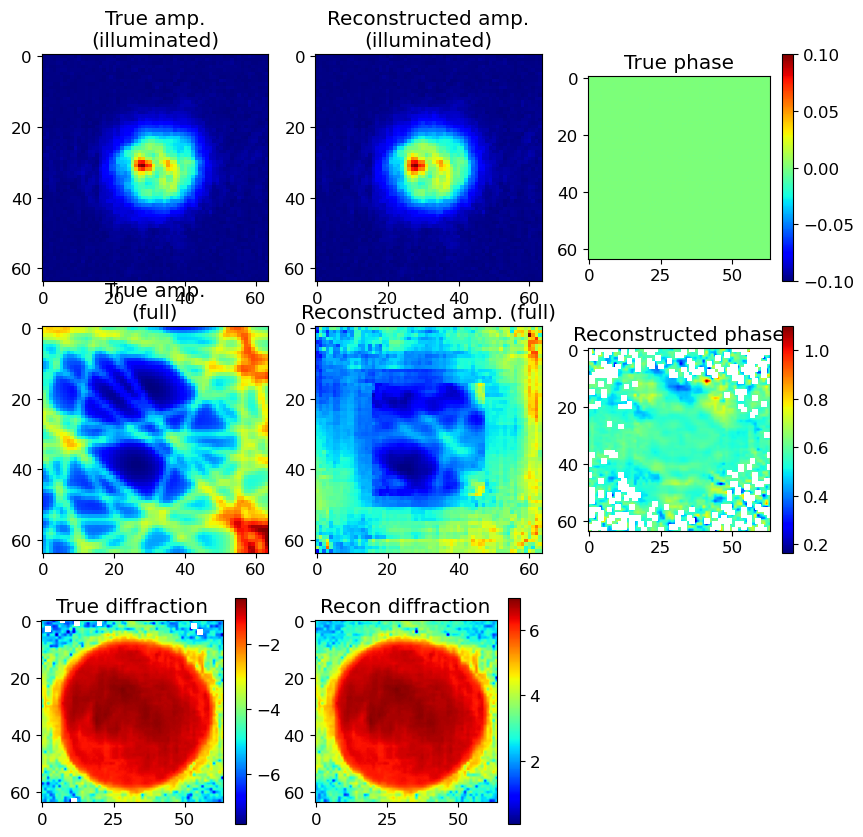

In [7]:
i = 500
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);

## Same thing with disk-shaped probe instead of xpp probe

In [6]:
# restart kernel here

In [9]:
init()

reload(probe)

<module 'ptycho.probe' from '/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/ptychoPINN-0.0.0-py3.9.egg/ptycho/probe.py'>

In [7]:
from importlib import reload
import matplotlib.pyplot as plt

def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = False
    p.cfg['data_source'] = 'lines'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 60

    p.cfg['offset'] = 4
    p.cfg['max_position_jitter'] = 3
    p.cfg['output_prefix'] = 'lines3'

    p.cfg['gridsize'] = 2
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    
    p.cfg['outer_offset_train'] = 8
    p.cfg['outer_offset_test'] = 20
    p.cfg['nimgs_train'] = 2
    p.cfg['nimgs_test'] = 2
    
init()
from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

from ptycho import params as p
from ptycho import generate_data as init

from ptycho import params as p
p.cfg['data_source'] = 'lines'
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'lines2'

p.cfg['gridsize'] = 2
p.cfg['n_filters_scale'] = 2
p.cfg['object.big'] = True
p.cfg['intensity_scale.trainable'] = True

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

In [23]:
create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0, name = 'lines_disk_probe_diffraction.gif',
                                  type = 'diffraction', show = False)

/tmp/ipykernel_1054468/458886421.py:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frames/frame_{i}.png'))


In [26]:
create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0, name = 'lines_disk_probe_amplitude.gif',
                                  type = 'amplitude', show = False)

/tmp/ipykernel_1054468/3297243131.py:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frames/frame_{i}.png'))


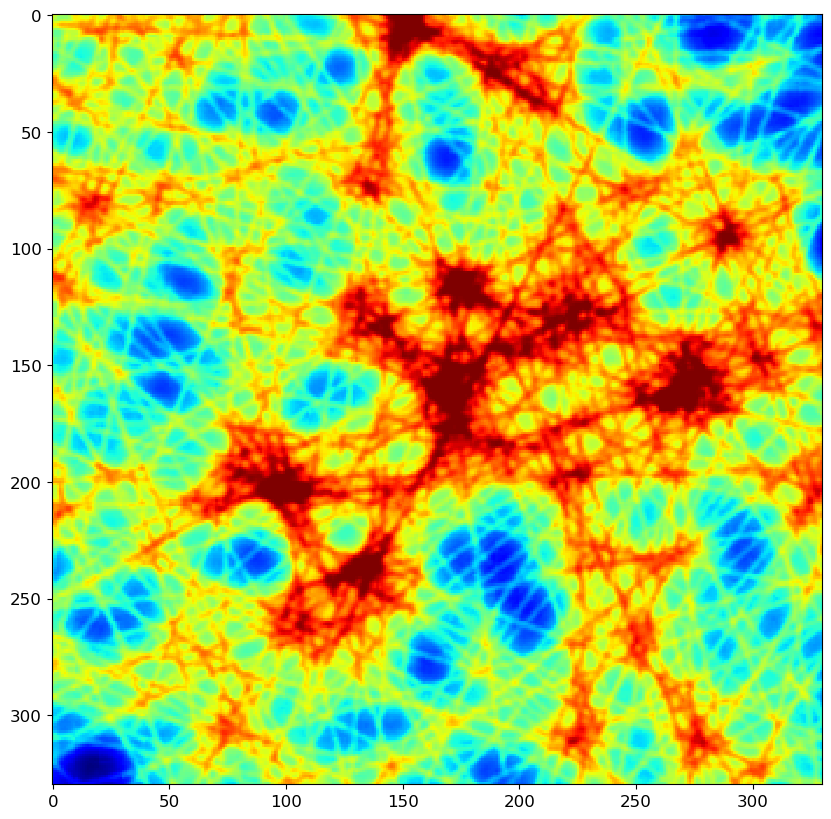

In [29]:
plt.rcParams["figure.figsize"] = (10, 10)

import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

In [ ]:
# from importlib import reload
# import matplotlib.pyplot as plt

# from ptycho import params as p
# from ptycho import generate_data as init
# # from ptycho import train

In [ ]:
# # reload(train.model)
# # reload(train_pinn)
# # reload(train)
# from ptycho.train import *

In [27]:
# reload(train.train_pinn)
# reload(train)
# from ptycho.train import *
# #plt.imshow(np.abs(p.params()['probe'][..., 0]))

### 2x2 grid:

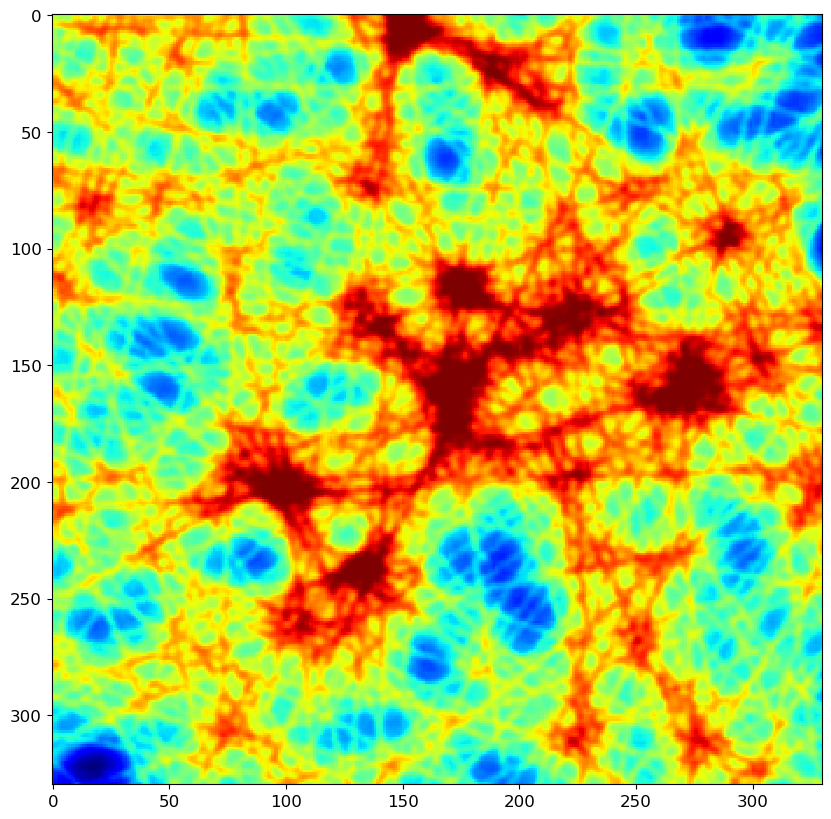

In [7]:
plt.rcParams["figure.figsize"] = (10, 10)

import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

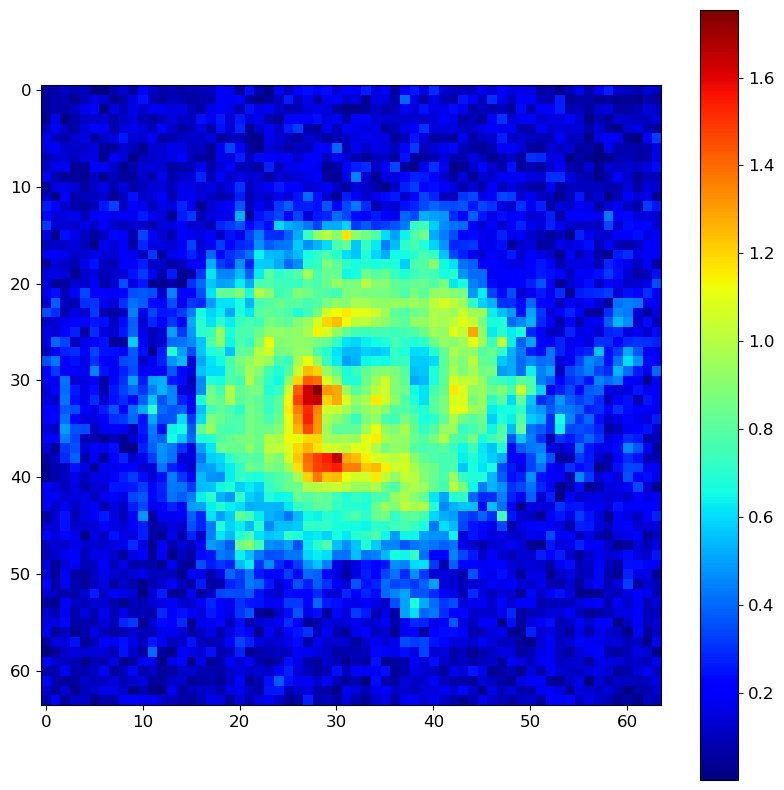

In [21]:
plt.imshow((probe_amp) / (probe_amp.T + .2), cmap = 'jet')
plt.colorbar()

phase min: -0.7186377 phase max: 1.0070891


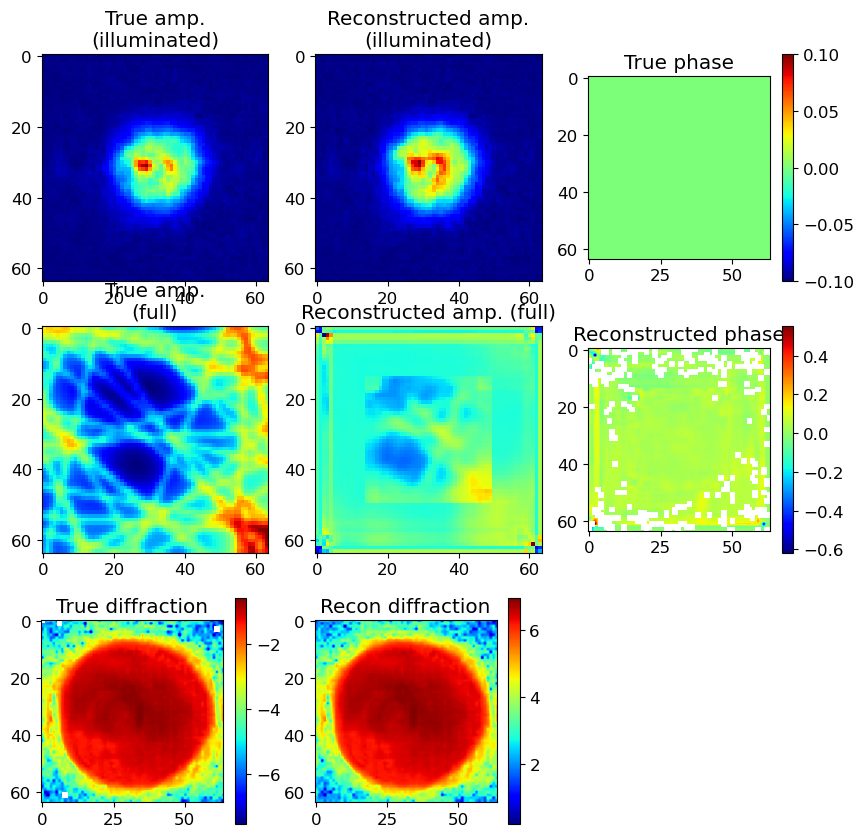

In [8]:
i = 500
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);

# Lines, xpp probe, 1x1

In [15]:
p.cfg['gridsize'] = 1
p.cfg['nll_weight'] = 1.

p.cfg['mae_weight'] = 0.
p.cfg['tv_weight'] = 0.0#50#1e1#1e1
p.cfg['realspace_mae_weight'] = 0.
p.cfg['realspace_weight'] = 0.

reload(model)
reload(train.train_pinn)
reload(train)
from ptycho.train import *

input shape (None, 64, 64, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['tf.math.truediv[0][0]']        
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                

 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 64, 1)    577         ['up_sampling2d_5[0][0]']        
                                                                                                  
 amp_padded (ZeroPadding2D)     (None, 64, 64, 1)    0           ['amp[0][0]']                    
                                                                                                  
 tf.nn.silu (TFOpLambda)        (None, 64, 64, 1)    0           ['conv2d_7[0][0]']               
                                                                                                  
 phase_pad

2023-12-08 02:30:38.149088: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-12-08 02:30:38.149103: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


using nominal scan positions for training


2023-12-08 02:30:38.443019: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-12-08 02:30:38.443124: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/60
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)
819/819 [==============================] - 14s 15ms/step - loss: 48983240.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 35.3858 - distribution_lambda_loss: 48983240.0000 - val_loss: 7874572.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 22.5126 - val_distribution_lambda_loss: 7874572.0000 - lr: 0.0010
Epoch 2/60
819/819 [==============================] - 12s 15ms/step - loss: 6225870.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 20.0868 - distribution_lambda_loss: 6225870.0000 - val_loss: 9257150.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 25.3212 - val_distribution_lambda_loss: 9257150.0000 - lr: 0.0010
Epoch 3/60
819/819 [==============================] - 12s 15ms/step - loss: 5591422.5000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 18.9757 - distribution_lambda_loss: 5591422.5000 - val_loss: 4452096.5000 - val_trimmed_obj_los

Epoch 44/60
819/819 [==============================] - 12s 15ms/step - loss: 724843.1250 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 7.1589 - distribution_lambda_loss: 724843.1250 - val_loss: 742088.5625 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 7.2382 - val_distribution_lambda_loss: 742088.5625 - lr: 1.0000e-04
Epoch 45/60
819/819 [==============================] - 12s 15ms/step - loss: 724885.3125 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 7.1541 - distribution_lambda_loss: 724885.3125 - val_loss: 736494.7500 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 7.2211 - val_distribution_lambda_loss: 736494.7500 - lr: 1.0000e-04
Epoch 46/60
819/819 [==============================] - 12s 15ms/step - loss: 711763.5625 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 7.0912 - distribution_lambda_loss: 711763.5625 - val_loss: 718635.3125 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 7.1157 - val_distributio

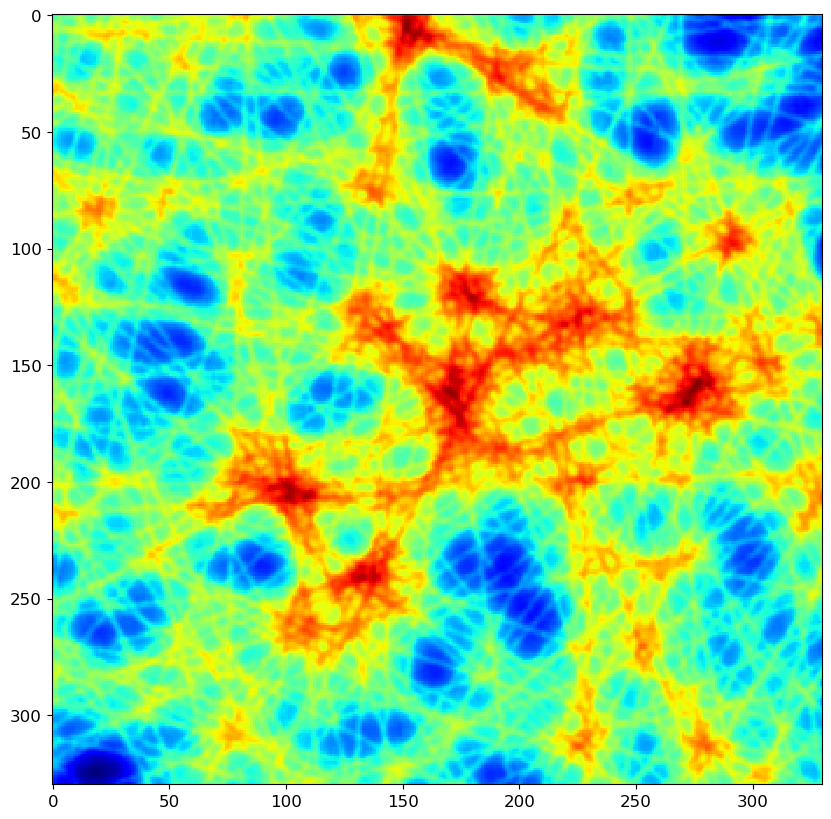

In [16]:
plt.rcParams["figure.figsize"] = (10, 10)

import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

## XPP data, full analysis

TODO: consistency checks on sign / swapping of coordinates

topics to highlight

* no free lunch (cdi ptycho)
* probe asymmetry
* subpixel resolution
* downsampling matt's data and clear description of the effects of doing that (does it fuck up position correction, etc.)
* combined cdi / ptycho objective
* does position correction help resolution?
* "by the way, this supervised model *isn't* ptychoNN, it's just ptychoPINN with a different configuration and one extra output and loss function. Might make sense to unify development efforts
* break down the reasons i had issues with overlaps

todos

* cdi-based position correction
* fix normalization / scaling issues
* joint CDI / ptycho objective

In [1]:
import scipy.ndimage
import matplotlib.pyplot as plt

from scipy.ndimage import zoom
import numpy as np

def shrinkpad(image):
    original_shape = image.shape
    # Shrink the image by a factor of two
    shrunken_image = zoom(image, 0.5)

    # Calculate the padding required
    pad_height = original_shape[0] - shrunken_image.shape[0]
    pad_width = original_shape[1] - shrunken_image.shape[1]

    # Pad the shrunken image to the original shape
    padded_image = np.pad(shrunken_image, ((pad_height // 2, pad_height // 2), (pad_width // 2, pad_width // 2)), mode='constant')
    return padded_image

def zoomclip(image):
    n, m = image.shape
    zoomed = zoom(image, 2)
    return zoomed[n // 2: -n // 2, m // 2: -m // 2]

def gaussian_2d(x, y, mux, muy, sigmax, sigmay):
    return np.exp(-((x - mux)**2 / (2 * sigmax**2) + (y - muy)**2 / (2 * sigmay**2)))

def create_gaussian_envelope(N, sigma):
    mux = muy = N / 2
    sigmax = sigmay = sigma
    x = np.linspace(0, N-1, N)
    y = np.linspace(0, N-1, N)
    X, Y = np.meshgrid(x, y)
    
    gaussian = gaussian_2d(X, Y, mux, muy, sigmax, sigmay)
    normalized_gaussian = gaussian / np.max(gaussian)
    
    return normalized_gaussian

gaussian_envelope = 1. * create_gaussian_envelope(64, 5)

In [2]:
def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = True
    p.cfg['data_source'] = 'xpp'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 20
    
    p.cfg['nll_weight'] = 1.
    p.cfg['mae_weight'] = 0.
    p.cfg['tv_weight'] = 0#1e1#1e1
    
    p.cfg['probe_scale'] = 6

    p.cfg['offset'] = 4
    p.cfg['sim_jitter_scale'] = 0.#0.1
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 2
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['probe.big'] = True
    
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e9
    
    p.cfg['outer_offset_train'] = None
    p.cfg['outer_offset_test'] = None
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1

init()

from ptycho import tf_helper
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf
from ptycho import params as p

from ptycho.xpp import *
# probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

2023-12-07 17:50:22.511469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 17:50:22.611715: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 17:50:23.046424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-12-07 17:50:23.046468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (5120, 64, 64, 4)


In [3]:
from ptycho import generate_data as init

1.345487282426179
nphoton 8.998595478452916


In [4]:
init.X_train.shape

(2560, 64, 64, 4)

In [5]:
from ptycho import params as p
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'tmp'

p.cfg['n_filters_scale'] = 2

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 4)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   2368        ['tf.math.truediv[0][0]']        
                                                             

                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 4)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15

2023-12-07 17:50:35.367039: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-12-07 17:50:35.367055: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-12-07 17:50:35.367076: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-12-07 17:50:35.368496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-12-07 17:50:35.423729: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-12-07 17:50:35.424147: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/20
input shape (64, 64, 64, 1)
input shape (64, 64, 64, 1)


2023-12-07 17:50:38.434821: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-07 17:50:39.549804: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7be9ec0


152/152 [==============================] - 6s 19ms/step - loss: 897766208.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 112.3220 - distribution_lambda_loss: 897766208.0000 - val_loss: 498511232.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 86.4022 - val_distribution_lambda_loss: 498511232.0000 - lr: 0.0010
Epoch 2/20
152/152 [==============================] - 2s 16ms/step - loss: 477332000.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 84.7237 - distribution_lambda_loss: 477332000.0000 - val_loss: 424264032.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 79.6022 - val_distribution_lambda_loss: 424264032.0000 - lr: 0.0010
Epoch 3/20
152/152 [==============================] - 2s 16ms/step - loss: 433499904.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 79.9305 - distribution_lambda_loss: 433499904.0000 - val_loss: 398605088.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 76.1465 - 

In [6]:
create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0, name = 'xpp_diffraction.gif',
                                  type = 'diffraction', show = False)

/tmp/ipykernel_1057834/3297243131.py:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frames/frame_{i}.png'))


In [7]:
create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0, name = 'xpp_amplitude.gif',
                                  type = 'amplitude', show = False)

/tmp/ipykernel_1057834/3297243131.py:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frames/frame_{i}.png'))


### Variation: convert the grid to 1x1 to solve in CDI mode. Relative coords of the 2x2 grid are retained, so we can remap the output to 2x2 and then feed that into position correction.

In [5]:
nn_indices_train = init.train_data['nn_indices'].reshape((-1, 1, 1, 4))
nn_indices_test = init.test_data['nn_indices'].reshape((-1, 1, 1, 4))
datavars = ['init.X_train', 'init.Y_I_train', 'init.Y_phi_train', 'init.Y_obj_train', 'init.X_test', 'init.Y_I_test', 'init.Y_phi_test',
            'init.Y_obj_test', 'init.coords_train_nominal',
            'init.coords_train_true', 'init.coords_test_nominal', 'init.coords_test_true',
           'nn_indices_train', 'nn_indices_test']
for d in datavars:
    exec('{} = hh._channel_to_flat({})'.format(d, d))

In [6]:
p.cfg['gridsize'] = 1

from ptycho import params as p
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'tmp'

p.cfg['n_filters_scale'] = 2

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['tf.math.truediv[0][0]']        
                                                             

                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15

2023-11-02 12:19:55.340857: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-11-02 12:19:55.340875: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-11-02 12:19:55.340897: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-11-02 12:19:55.345073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-11-02 12:19:55.399022: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-11-02 12:19:55.399348: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/20
input shape (16, 64, 64, 1)
input shape (16, 64, 64, 1)


2023-11-02 12:19:57.035100: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1c41e430
2023-11-02 12:19:57.764040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


608/608 [==============================] - 12s 15ms/step - loss: 73538536.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 55.7297 - distribution_lambda_loss: 73538536.0000 - val_loss: 22826628.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 40.1581 - val_distribution_lambda_loss: 22826628.0000 - lr: 0.0010
Epoch 2/20
608/608 [==============================] - 9s 14ms/step - loss: 19492390.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 37.0884 - distribution_lambda_loss: 19492390.0000 - val_loss: 15841025.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 33.5850 - val_distribution_lambda_loss: 15841025.0000 - lr: 0.0010
Epoch 3/20
608/608 [==============================] - 9s 14ms/step - loss: 15731203.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 33.4645 - distribution_lambda_loss: 15731203.0000 - val_loss: 14221287.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 32.1643 - val_distrib

In [40]:
# plt.imshow(np.absolute(p.get('probe')[:, :, 0]))

phase min: -3.1415927 phase max: 3.1415925


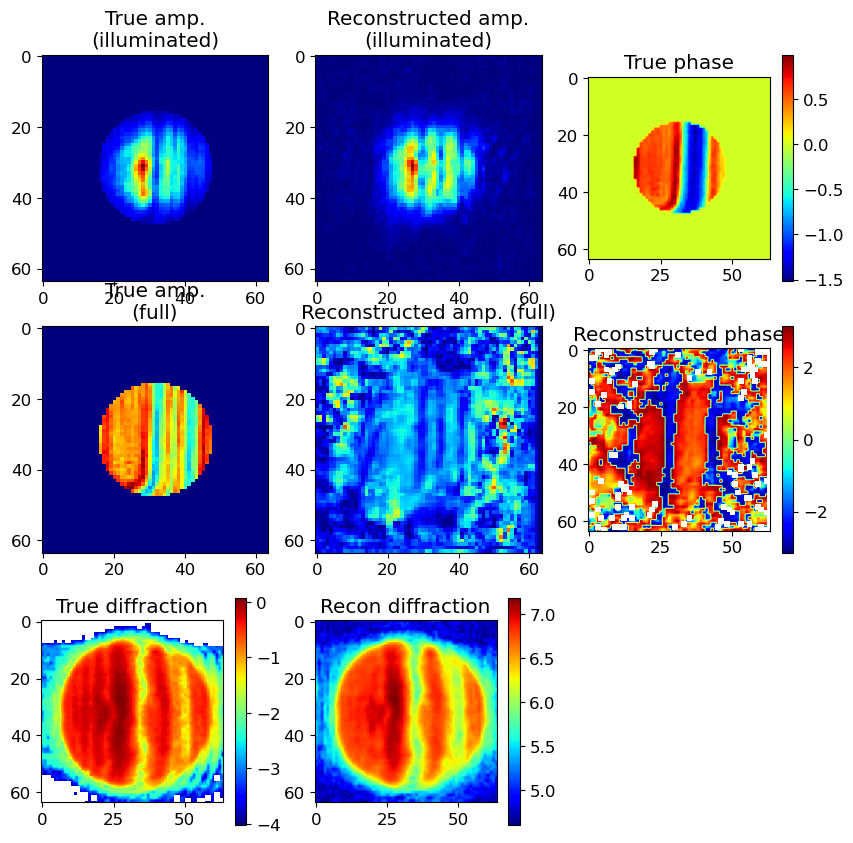

In [36]:
absprobe = np.absolute(p.get('probe')[:, :, 0])
i = 0
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 100, reconstructed_obj, X_test,
                     (Y_I_test * absprobe[..., None]),
                     Y_phi_test, absprobe, 0, crop=False);

In [ ]:
# absprobe = np.absolute(p.get('probe')[:, :, 0])
# i = 100
# from ptycho import evaluation
# evaluation.summarize(i, pred_amp + 100, reconstructed_obj, X_test,
#                      (Y_I_test * absprobe[..., None]),
#                      Y_phi_test, absprobe, 0, crop=False);

# XPP data, 1x1 grid:

## Demo starts here

In [2]:
init()

from ptycho import tf_helper
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

2024-01-08 20:38:19.483664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 20:38:19.578477: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 20:38:20.010525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/:/home/ollie/anaconda3/envs/tf/lib/
2024-01-08 20:38:20.010600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (1024, 64, 64, 1)


In [3]:
tf.random.set_seed(45)
from ptycho import params as p

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

nphoton 8.998538127015522
1.3507012042334168
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['tf.math.truediv[0][0]']        
                

                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15

2024-01-08 20:38:23.265100: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-08 20:38:23.265120: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-08 20:38:23.265153: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-01-08 20:38:23.265334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/:/home/ollie/anaconda3/envs/tf/lib/
2024-01-08 20:38:23.344561: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-08 20:38:23.344669: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/100
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2024-01-08 20:38:24.924749: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7c9be90
2024-01-08 20:38:25.911467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


31/31 [==============================] - 5s 39ms/step - loss: 184800352.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 106.5604 - distribution_lambda_loss: 184800352.0000 - val_loss: 136176416.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 92.0685 - val_distribution_lambda_loss: 136176416.0000 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 115582920.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 84.6710 - distribution_lambda_loss: 115582920.0000 - val_loss: 98523744.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 78.1388 - val_distribution_lambda_loss: 98523744.0000 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 87792656.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 74.1994 - distribution_lambda_loss: 87792656.0000 - val_loss: 77898040.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 70.4947 - val_distr

Epoch 23/100
31/31 [==============================] - 0s 15ms/step - loss: 17530952.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 35.3982 - distribution_lambda_loss: 17530952.0000 - val_loss: 17809972.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 35.5151 - val_distribution_lambda_loss: 17809972.0000 - lr: 5.0000e-04
Epoch 24/100
31/31 [==============================] - 0s 15ms/step - loss: 16670694.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 34.5648 - distribution_lambda_loss: 16670694.0000 - val_loss: 17549794.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 35.3583 - val_distribution_lambda_loss: 17549794.0000 - lr: 5.0000e-04
Epoch 25/100
31/31 [==============================] - 0s 15ms/step - loss: 16368238.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 34.2428 - distribution_lambda_loss: 16368238.0000 - val_loss: 17444876.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 35.

31/31 [==============================] - 0s 15ms/step - loss: 11857027.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 29.3398 - distribution_lambda_loss: 11857027.0000 - val_loss: 13340023.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 30.9545 - val_distribution_lambda_loss: 13340023.0000 - lr: 2.5000e-04
Epoch 46/100
31/31 [==============================] - 0s 15ms/step - loss: 11650014.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 29.0885 - distribution_lambda_loss: 11650014.0000 - val_loss: 13359390.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 31.0280 - val_distribution_lambda_loss: 13359390.0000 - lr: 2.5000e-04
Epoch 47/100
31/31 [==============================] - 0s 15ms/step - loss: 11691444.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 29.1510 - distribution_lambda_loss: 11691444.0000 - val_loss: 13121659.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 30.6208 - val_di

31/31 [==============================] - 0s 15ms/step - loss: 9642884.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 26.5389 - distribution_lambda_loss: 9642884.0000 - val_loss: 11577684.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 28.8387 - val_distribution_lambda_loss: 11577684.0000 - lr: 1.2500e-04
Epoch 68/100
31/31 [==============================] - 0s 15ms/step - loss: 9592696.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 26.4736 - distribution_lambda_loss: 9592696.0000 - val_loss: 11589979.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 28.8795 - val_distribution_lambda_loss: 11589979.0000 - lr: 1.2500e-04
Epoch 69/100
29/31 [===========================>..] - ETA: 0s - loss: 9563853.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 26.4446 - distribution_lambda_loss: 9563853.0000
Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0001.
31/31 [==============================] - 0s 15ms/step -

31/31 [==============================] - 0s 15ms/step - loss: 8774100.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 25.3532 - distribution_lambda_loss: 8774100.0000 - val_loss: 11137329.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 28.3136 - val_distribution_lambda_loss: 11137329.0000 - lr: 1.0000e-04
Epoch 90/100
31/31 [==============================] - 0s 15ms/step - loss: 8812731.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 25.4105 - distribution_lambda_loss: 8812731.0000 - val_loss: 10967323.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 27.9999 - val_distribution_lambda_loss: 10967323.0000 - lr: 1.0000e-04
Epoch 91/100
31/31 [==============================] - 0s 15ms/step - loss: 8690663.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 25.2337 - distribution_lambda_loss: 8690663.0000 - val_loss: 10853266.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 27.9494 - val_distribu

In [4]:
%%time
obj_tensor_full, global_offsets, local_offsets = reconstruct_image()
recon_amp_ptychopinn = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase_ptychopinn = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

# ptycho_pinn_phase = crop_to_non_uniform_region_with_buffer(recon_phase_ptychopinn[..., 0], buffer=23)
# ptycho_pinn_amplitude = crop_to_non_uniform_region_with_buffer(recon_amp_ptychopinn[..., 0], buffer=23)
ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]



input shape (32, 64, 64, 1)
32/32 [==============================] - 1s 22ms/step
CPU times: user 1.26 s, sys: 149 ms, total: 1.41 s
Wall time: 1.32 s


In [5]:
%timeit -n 1 -r 1 model.diffraction_to_obj.predict(xpp.X_full * model.params()['intensity_scale'])

32/32 [==============================] - 0s 8ms/step
450 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
#plot_xpp_phase()

In [8]:
from IPython.display import HTML
gif_file = 'animation.gif'

# HTML to display two GIFs side by side
html = f"""
<table>
<tr>
<td><img src="{gif_file}" alt="GIF 2"></td>
</tr>
</table>
"""

# Display the HTML
display(HTML(html))

""


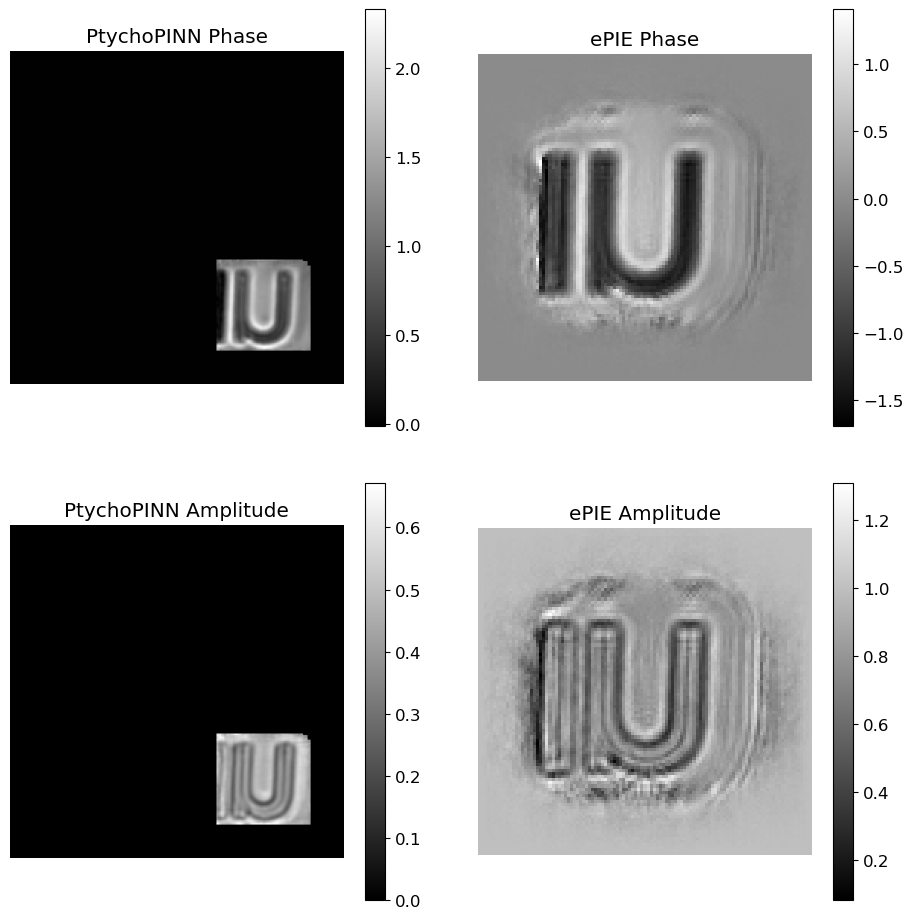

In [6]:
recon_amp = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']))
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']))


mk_epie_comparison2x2()

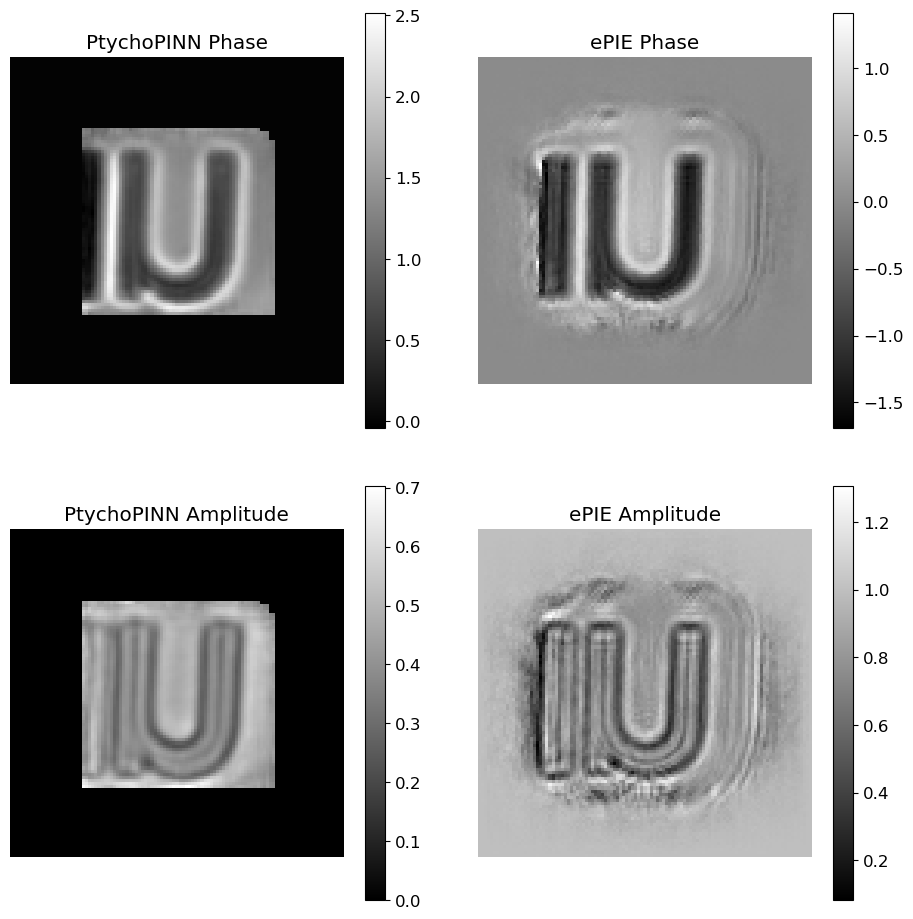

In [9]:
recon_amp = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']))
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']))


mk_epie_comparison2x2()

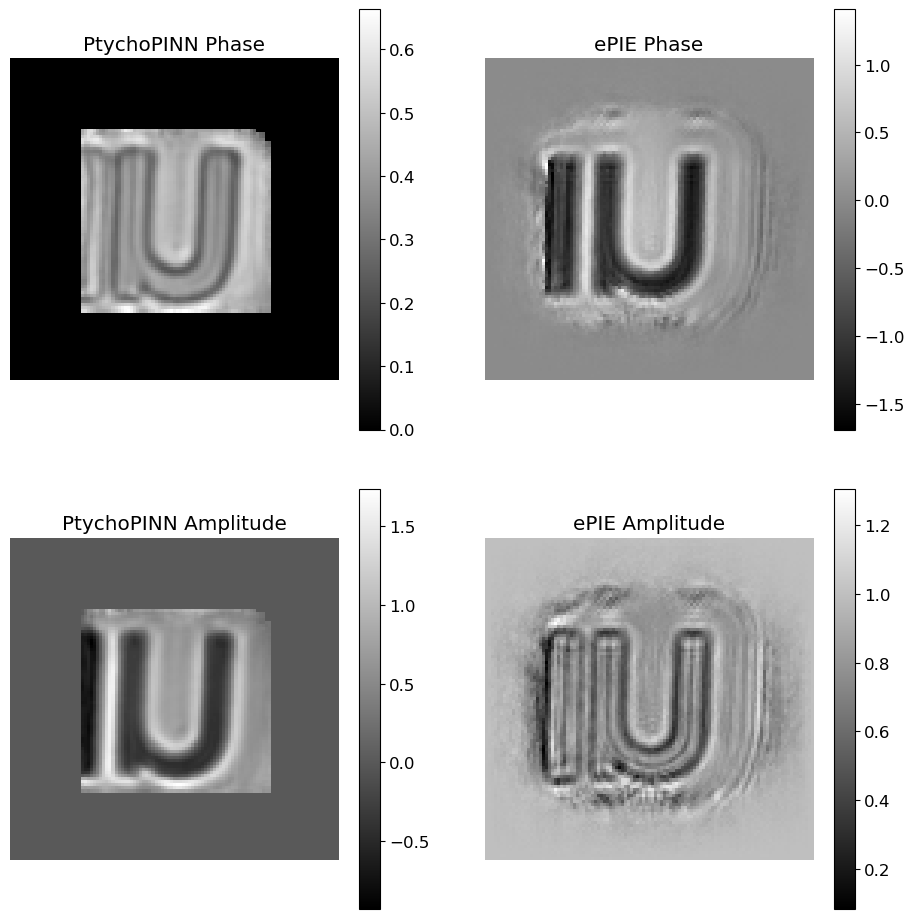

In [9]:
recon_amp = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']))
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']))


mk_epie_comparison2x2()

In [10]:
# animation_html = create_animation(500, 10, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
#                      np.absolute(p.get('probe')[:, :, 0]), 0, show = False)

# Supervised ptychoPINN

In [11]:
p.cfg['gridsize'] = 1
p.cfg['nll_weight'] = 0.
p.cfg['mae_weight'] = 0.
p.cfg['tv_weight'] = 0.0
p.cfg['realspace_mae_weight'] = 1.
p.cfg['realspace_weight'] = 1.

In [13]:
tf.random.set_seed(43)
reload(train_pinn.model)
reload(train.train_pinn)
reload(train)
from ptycho.train import *

input shape (None, 64, 64, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['tf.math.truediv[0][0]']        
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                

 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 64, 1)    577         ['up_sampling2d_5[0][0]']        
                                                                                                  
 amp_padded (ZeroPadding2D)     (None, 64, 64, 1)    0           ['amp[0][0]']                    
                                                                                                  
 tf.nn.silu (TFOpLambda)        (None, 64, 64, 1)    0           ['conv2d_7[0][0]']               
                                                                                                  
 phase_pad

2023-12-08 17:02:49.157086: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-12-08 17:02:49.157101: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


using provided scan positions for training
Epoch 1/100


2023-12-08 17:02:49.483348: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-12-08 17:02:49.483457: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)
31/31 [==============================] - 2s 27ms/step - loss: 0.8578 - trimmed_obj_loss: 0.8578 - tf.math.multiply_loss: 171.2602 - distribution_lambda_loss: 466423872.0000 - val_loss: 0.5406 - val_trimmed_obj_loss: 0.5406 - val_tf.math.multiply_loss: 259.8518 - val_distribution_lambda_loss: 937773376.0000 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.4626 - trimmed_obj_loss: 0.4626 - tf.math.multiply_loss: 194.2110 - distribution_lambda_loss: 588996160.0000 - val_loss: 0.4814 - val_trimmed_obj_loss: 0.4814 - val_tf.math.multiply_loss: 175.1993 - val_distribution_lambda_loss: 422480192.0000 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.3966 - trimmed_obj_loss: 0.3966 - tf.math.multiply_loss: 170.8981 - distribution_lambda_loss: 425562304.0000 - val_loss: 0.4252 - val_trimmed_obj_loss: 0.4252 - val_tf.math.multiply_loss: 171.6620 - val_distrib

In [14]:
obj_tensor_full, global_offsets, local_offsets = reconstruct_image()

input shape (32, 64, 64, 1)
32/32 [==============================] - 1s 21ms/step


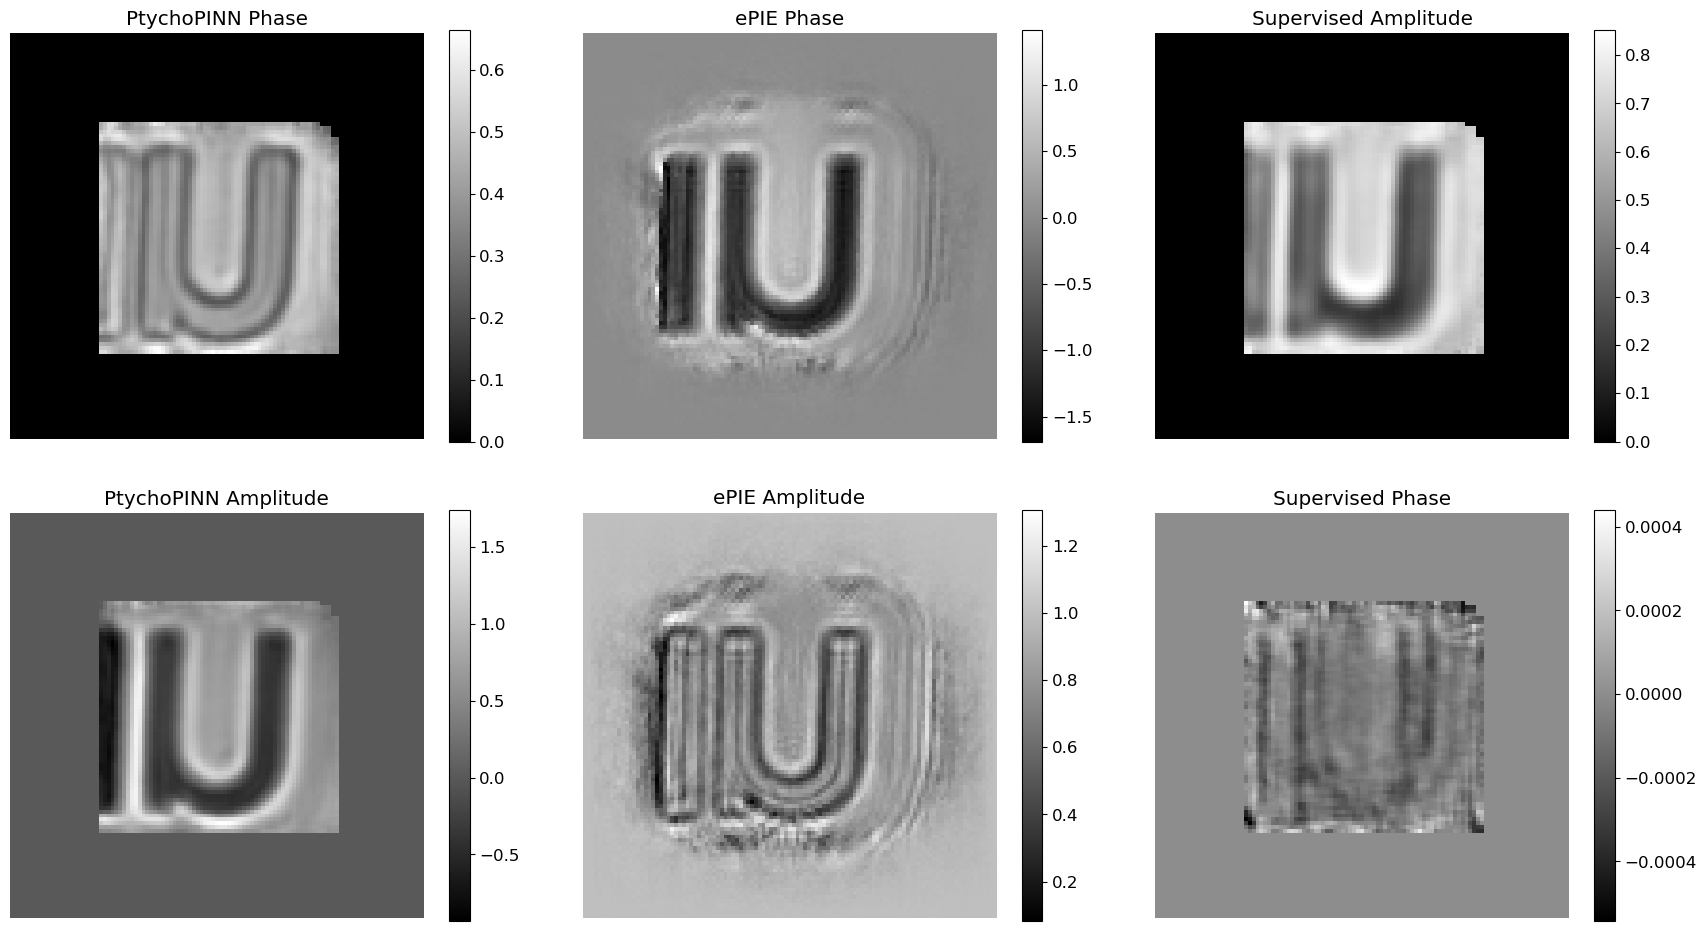

In [16]:
recon_amp_supervised = np.absolute(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))

recon_phase_supervised = np.angle(loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 20))


supervised_amplitude = crop_to_non_uniform_region_with_buffer(recon_amp_supervised[..., 0], buffer=23)
supervised_phase = crop_to_non_uniform_region_with_buffer(recon_phase_supervised[..., 0], buffer=23)


plot_epie_comparison_2x3()

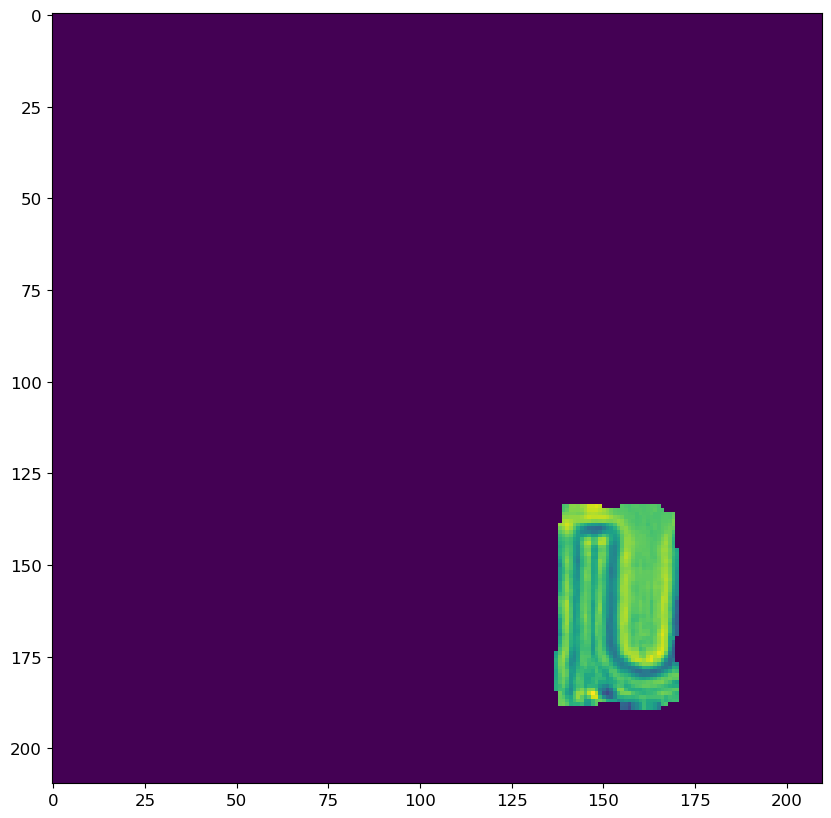

In [37]:
plt.imshow(loader.reassemble_position(patches, global_offsets[:, :, ::-1, :]))

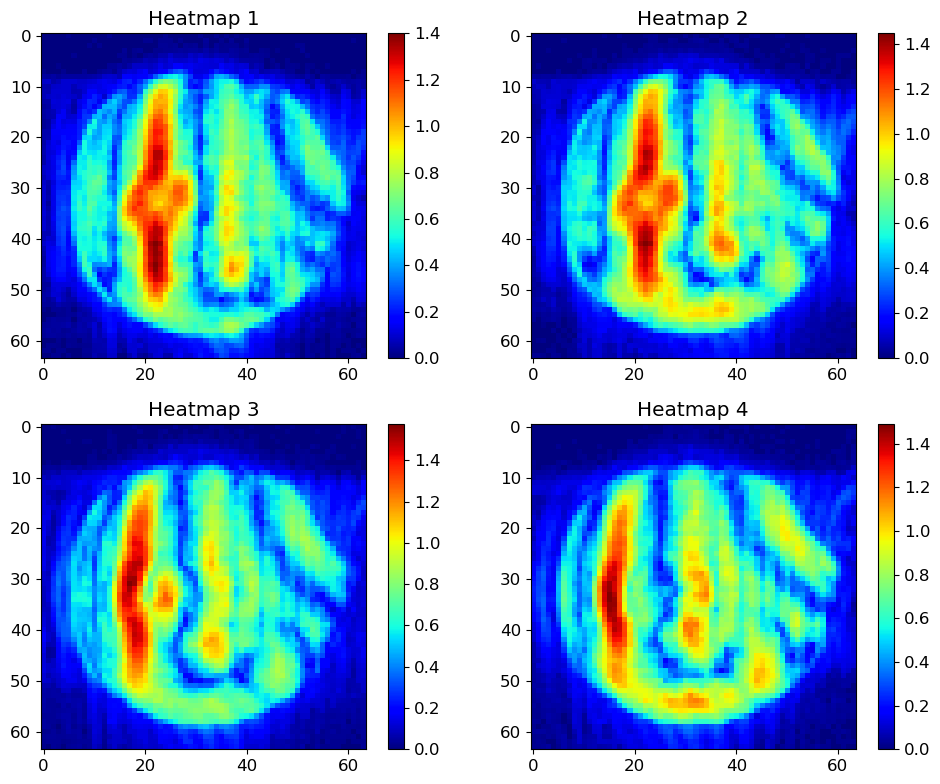

In [34]:
data = diff4d_nn[1000]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Loop through the data and plot each heatmap in a subplot
for i in range(4):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    heatmap = ax.imshow(data[..., i], cmap='jet', interpolation='nearest')
    ax.set_title(f"Heatmap {i + 1}")
    fig.colorbar(heatmap, ax=ax)  # Add colorbar to each subplot

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## PtychoNN

In [1]:
def init():
    from ptycho import params as p
    p.cfg['model_type'] = 'supervised'
    p.cfg['positions.provided'] = True
    p.cfg['data_source'] = 'xpp'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 30
    
    p.cfg['nll_weight'] = 1.
    p.cfg['mae_weight'] = 0.
    p.cfg['tv_weight'] = 0#50#1e1#1e1
    
    p.cfg['probe_scale'] = 5

    p.cfg['offset'] = 4
    p.cfg['sim_jitter_scale'] = 0.#0.1
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 1
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['probe.big'] = True
    
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e9
    
    p.cfg['outer_offset_train'] = None
    p.cfg['outer_offset_test'] = None
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1

init()

from ptycho import tf_helper
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

2023-09-04 23:56:11.694039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 23:56:11.780231: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 23:56:12.167205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-09-04 23:56:12.167248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (5120, 64, 64, 1)


In [2]:
from ptycho import params as p

# from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

1.3954099226331658
nphoton 8.998598525490301
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 1)    0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['tf.math.truediv[0][0]']        
                

                                                                 ]']                              
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 64, 64, 64)  0           ['conv2d_21[0][0]']              
                                                                                                  
 amp (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    577         ['up_sampling2d_2[0][0]']        
                                                                                                  
 phi (Lambda)                   (None, 32, 32, 1)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15

                                                                                                  
 conv2d_14 (Conv2D)             (None, 8, 8, 256)    590080      ['conv2d_13[0][0]']              
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 256)  0           ['conv2d_7[0][0]']               
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 16, 16, 256)  0          ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 128)  295040      ['up_sampling2d[0][0]']          
                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 128)  295040      ['up_sampling2d_3[0][0]']        
          

2023-09-04 23:56:18.237675: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-09-04 23:56:18.237692: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-09-04 23:56:18.237712: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-09-04 23:56:18.242000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-09-04 23:56:18.294588: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-09-04 23:56:18.294682: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/30


2023-09-04 23:56:19.545966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


76/76 [==============================] - 4s 22ms/step - loss: 0.6671 - conv2d_12_loss: 0.3902 - conv2d_19_loss: 0.2769 - val_loss: 0.1580 - val_conv2d_12_loss: 0.0488 - val_conv2d_19_loss: 0.1092 - lr: 0.0010
Epoch 2/30
76/76 [==============================] - 2s 20ms/step - loss: 0.1132 - conv2d_12_loss: 0.0365 - conv2d_19_loss: 0.0767 - val_loss: 0.0860 - val_conv2d_12_loss: 0.0328 - val_conv2d_19_loss: 0.0532 - lr: 0.0010
Epoch 3/30
76/76 [==============================] - 2s 20ms/step - loss: 0.0811 - conv2d_12_loss: 0.0319 - conv2d_19_loss: 0.0491 - val_loss: 0.0729 - val_conv2d_12_loss: 0.0298 - val_conv2d_19_loss: 0.0431 - lr: 0.0010
Epoch 4/30
76/76 [==============================] - 2s 20ms/step - loss: 0.0695 - conv2d_12_loss: 0.0299 - conv2d_19_loss: 0.0396 - val_loss: 0.0715 - val_conv2d_12_loss: 0.0305 - val_conv2d_19_loss: 0.0410 - lr: 0.0010
Epoch 5/30
76/76 [==============================] - 2s 20ms/step - loss: 0.0644 - conv2d_12_loss: 0.0279 - conv2d_19_loss: 0.0366 -

In [3]:
Y_test = hh.combine_complex(Y_I_test, Y_phi_test)
global_offsets = xpp.dset[xpp.key_coords_offsets]# xpp.split_tensor(xpp.dset[xpp.key_coords_offsets], 'test')
local_offsets = xpp.dset[xpp.key_coords_relative]
# from ptycho import generate_data as init

global_offsets_test = xpp.split_tensor(
    xpp.dset[xpp.key_coords_offsets], 'test')
local_offsets_test = xpp.split_tensor(
    xpp.dset[xpp.key_coords_relative], 'test')

obj_tensor_full, _, _, _ = model.autoencoder.predict(
                [xpp.X_full * model.params()['intensity_scale'],
                                xpp.dset[xpp.key_coords_relative]])

# obj_tensor_test, _, _, _ = model.autoencoder.predict(
#                 [X_test * model.params()['intensity_scale'],
#                                 local_offsets_test])

input shape (32, 64, 64, 1)
160/160 [==============================] - 4s 23ms/step


In [7]:
recon_obj = loader.reassemble_position(obj_tensor_full,
                                                  global_offsets[:, :, :, :],
                                              M = 10)

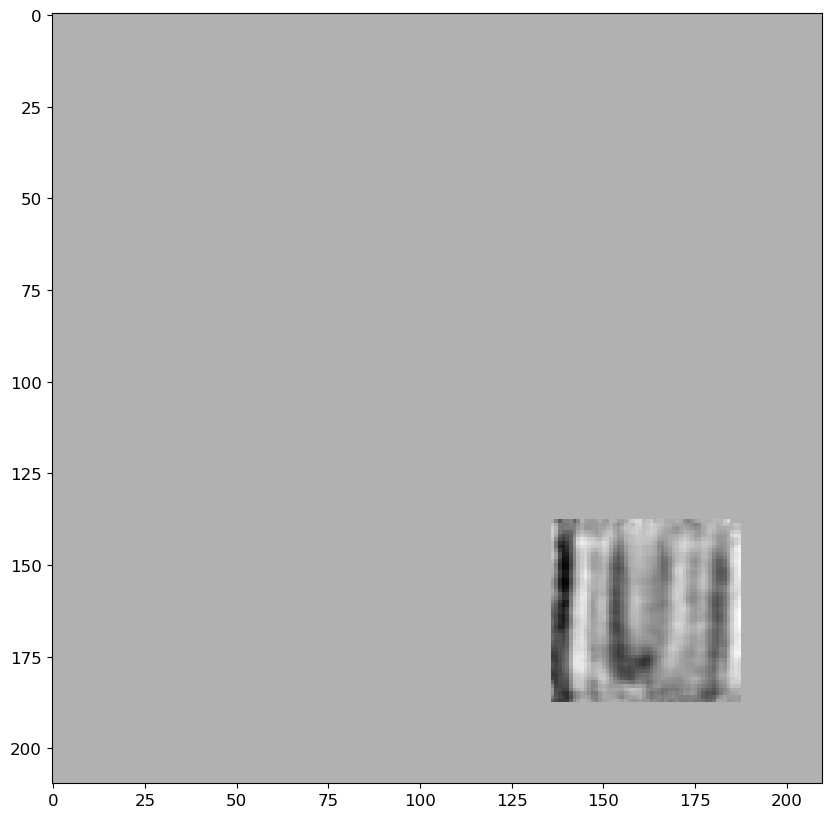

In [8]:
# recon_phase = np.angle(loader.reassemble_position(obj_tensor_test,
#                                                   global_offsets_test[..., :],
#                                               M = 20))
# plt.imshow(recon_phase, cmap = 'gray')

recon_phase = np.angle(recon_obj)

plt.imshow(recon_phase,
         cmap = 'gray')

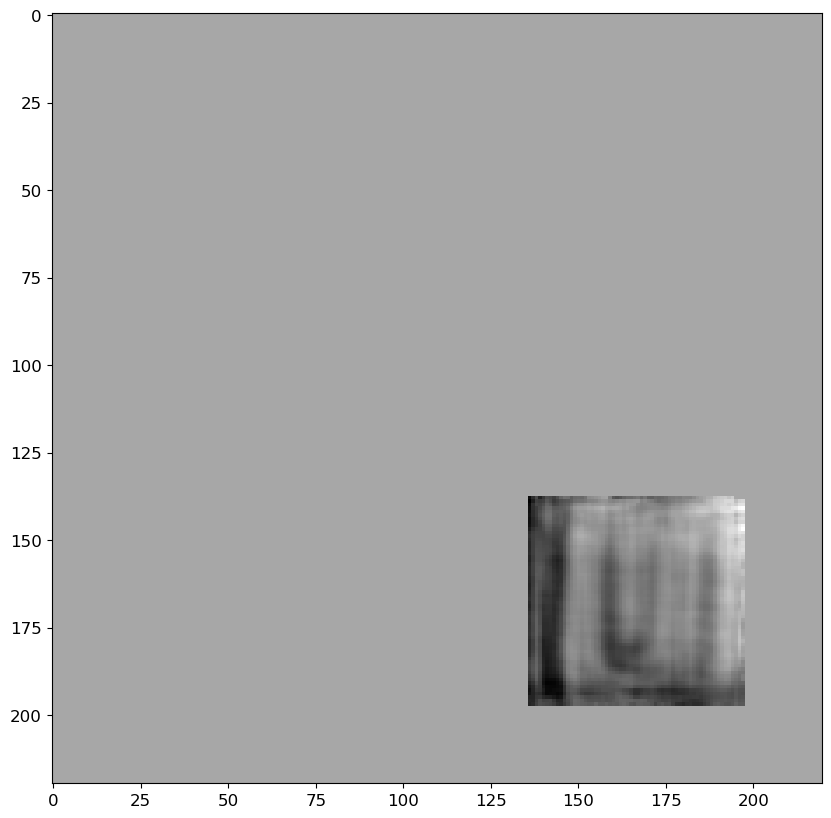

In [5]:
# recon_phase = np.angle(loader.reassemble_position(obj_tensor_test,
#                                                   global_offsets_test[..., :],
#                                               M = 20))
# plt.imshow(recon_phase, cmap = 'gray')

recon_phase = np.angle(recon_obj)

plt.imshow(recon_phase,
         cmap = 'gray')

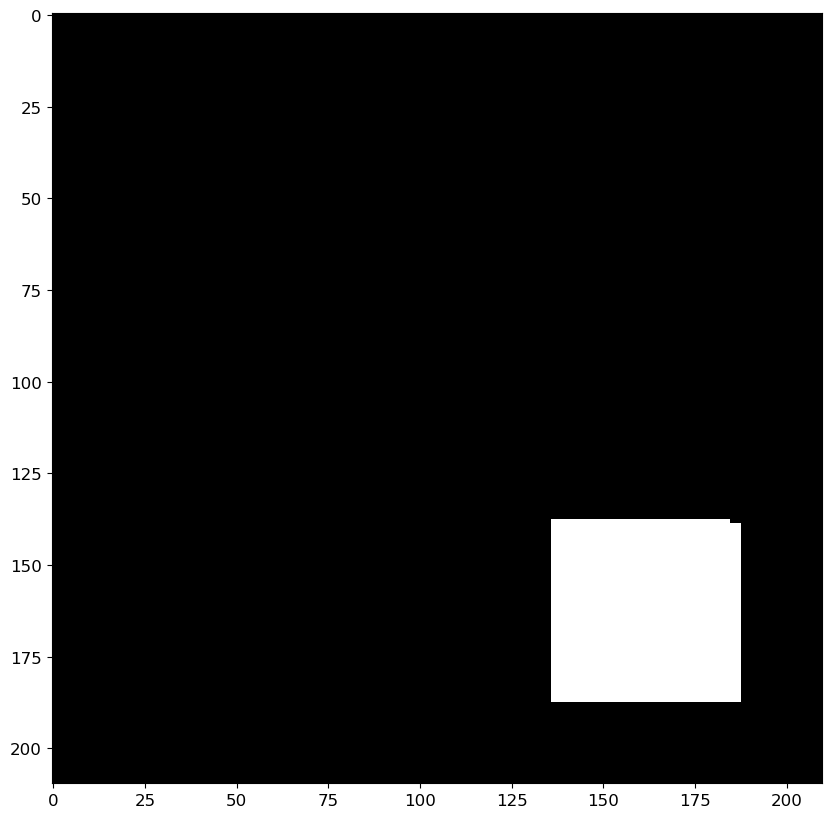

In [9]:
recon_amp = np.absolute(recon_obj)

plt.imshow(recon_amp,
         cmap = 'gray')

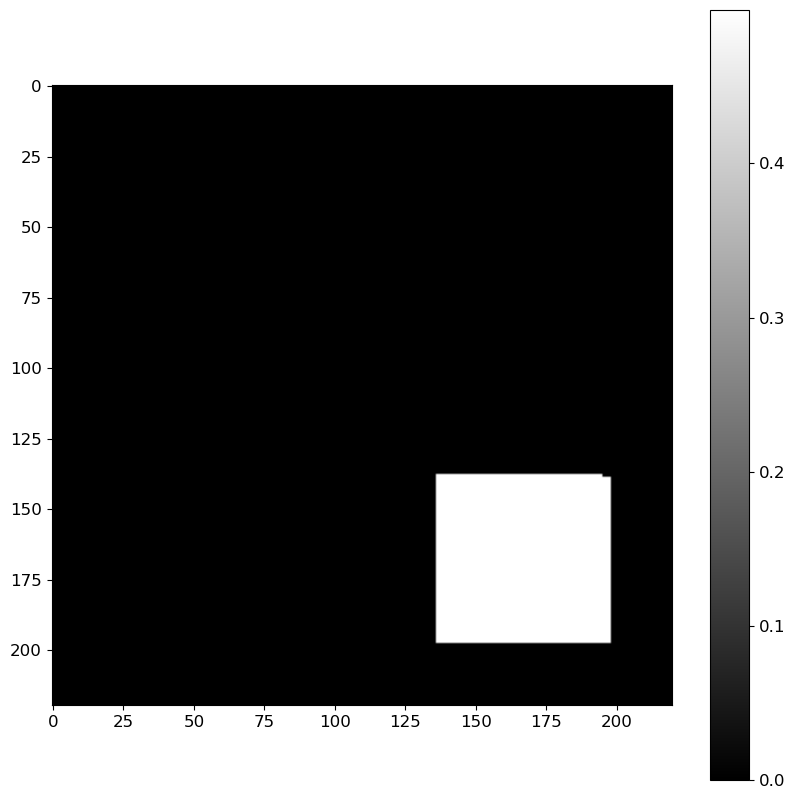

In [8]:
recon_amp = np.abs(recon_obj)

plt.imshow(recon_amp,
         cmap = 'gray')
plt.colorbar()

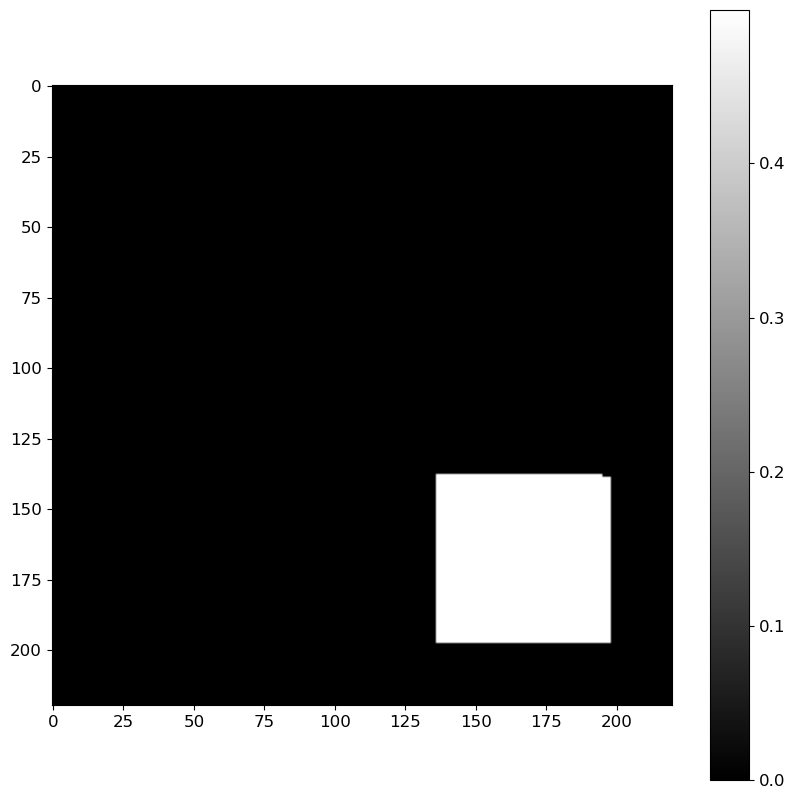

In [17]:
recon_amp = np.abs(recon_obj)

plt.imshow(recon_amp,
         cmap = 'gray')
plt.colorbar()